# EDS 220 Fall 2022
# Map projections with Google Earth Engine

Google Earth Engine is an extremely powerful tool for visualizing environmental data, making it an extremely popular choice in many contexts. However, the combination of Google Earth Engine with Cartopy is even more powerful, combining the on-the-fly ability of GEE to access and analyze data with Cartopy's strengths in map reprojection and generation of production-quality graphics.

To facilitate the use of Cartopy, we'll use the `cartoee` package. Cartoee functions as a 'go-between' for Earth Engine and Cartopy, by requesting images from Earth Engine and passing them through to Cartopy. In that way, the data can be reprojected as desired using Cartopy without the user having to download all the data from Earth Engine.

First, we import the relevant packages and initialize the Earth Engine environment:

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from geemap import cartoee
import matplotlib.pyplot as plt

In [2]:
# Authenticate and initialize GEE
#ee.Authenticate()
ee.Initialize()

Next, let's load some data. We can work with the same dataset that was used for the last set of exercises: the Landsat 8 TOA reflectances. As a reminder, the path below refers to:

 - The Landsat 8 mission (LC08)
 - Data Collection 1 (C01); this is the first "official" collection of Landsat data ingested into GEE, which will eventually be superseded by Collection 2 but will be maintained through the end of 2022
 - Tier 1 data (T1), the highest data quality 


In [3]:
# Load the Landsat 8 Tier 1 TOA image collection
gdat = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')

Instead of filtering the data to a single point, as we did in the `Landsat_colormaps_GEE` notebook, we can retain global information and still reduce the size of the dataset by filtering on the time dimension instead.

In [4]:
# Use filter to extract all "non-cloudy" images: ones with less than 20% cloud cover
dat_nocld=gdat.filter('CLOUD_COVER < 0.2')

# Command to extract all data over appropriate time, perform temporal averaging
dat_2018=dat_nocld.filter(ee.Filter.date('2018-6-1', '2018-12-31')).mean();

To choose a set of bands to visualize, let's go with true-color: here that means assigning R, G, and B values to the measurements made by Landsat in the visible red, green, and blue wavelength ranges respectively.

The code block below also excludes the higher-latitude regions, to reduce the amount of data being extracted from Earth Engine.

__**note: if you change the region limits below, this may have a significant impact on the amount of time your code takes to run!**__

Typical run times are several minutes for the 50S-70N range depicted below. So be patient! 

In [5]:
# Visualization parameters: which bands are we assigning to R, G, and B?
visParams = {'bands': ['B4', 'B3', 'B2'],
             'min': 0,
             'max': 0.3
            }

# specify region to focus on
bbox = [-180, -50, 180, 70]

When the plot is generated, we can also use all of the functionality of Cartopy to set the plot parameters. Below, I've drawn in the coast outlines using `ax.coastlines()`, and used the `ax.gridlines` module to draw semitransparent gray dashed lat/lon grid lines:

/Users/samstevenson/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:384: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


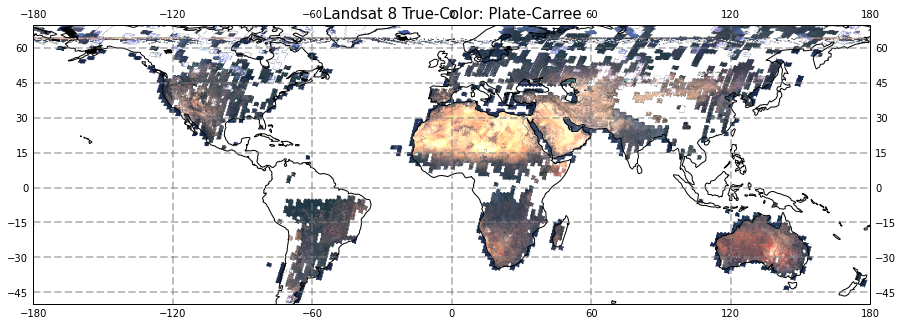

In [6]:
fig = plt.figure(figsize=(15, 10))

# create a new Plate-Carree projection 
projection = ccrs.PlateCarree()

# plot the result with cartoee 
ax = cartoee.get_map(dat_2018, vis_params=visParams, region=bbox, proj=projection)

ax.set_title(label='Landsat 8 True-Color: Plate-Carree', fontsize=15)

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.show()